# Интро

15 апреля 1912 года, во время своего первого рейса, широко известный как “непотопляемый” **"Титаник"** затонул после столкновения с айсбергом.

Хотя в выживании был определенный элемент удачи, похоже, что у некоторых групп людей было больше шансов выжить, чем у других.

В этой задаче нам предстоит построить прогностическую модель, которая отвечает на вопрос: ~мог ли Лео забраться на дверь?~ **у каких людей было больше шансов выжить?**

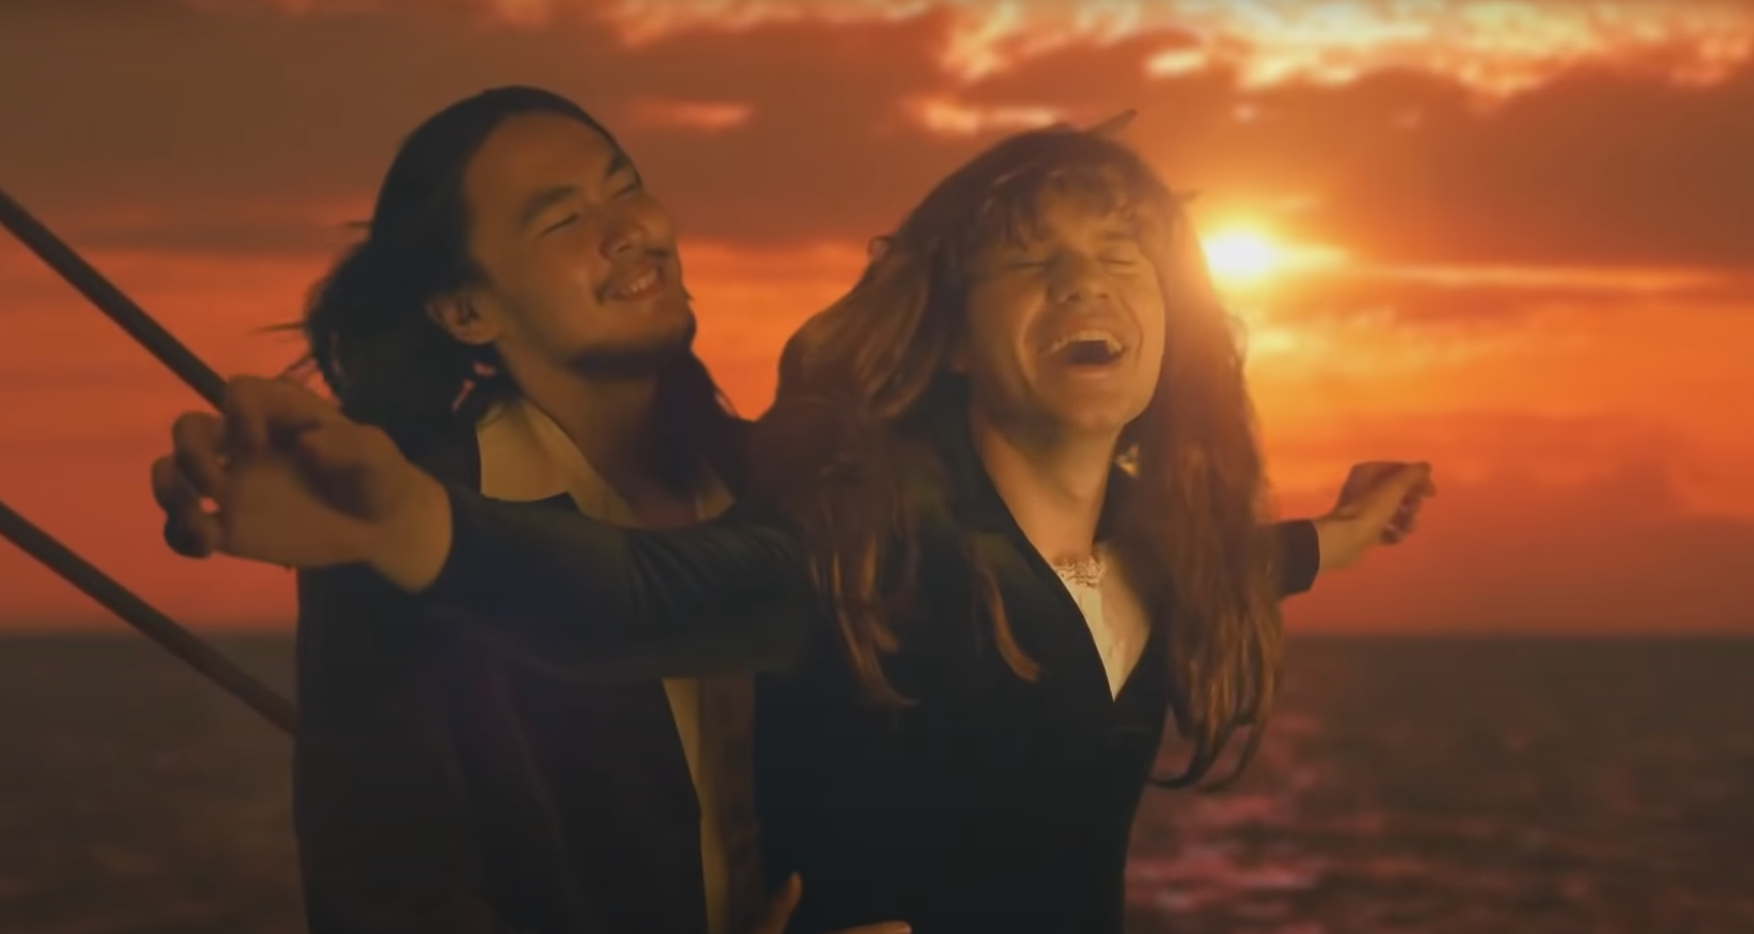

# Библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import warnings
warnings.filterwarnings('ignore')
import time
import re

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB


# Данные

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#shape
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

Train set shape: (891, 12)
Test set shape: (418, 11)


In [3]:
# превью
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Описание данных:**

> * **PassengerId** - Уникальный номер пассажира.
> * **Survived** - Выжил пассажир (1) или нет (0). Это наш `таргет`
> * **Pclass** - Показатель социально-экономического статуса (СЭС): 1 - 1st - Высокий; 2 - 2nd - Средний; 3 - 3rd - Низкий.
> * **Name** - Имя, с конструкцией которого нужно еще разобраться (мб понадобится для заполнения пропусков).
> * **Sex** - Пол.
> * **SibSp** - Количество братьев и сестер / супругов на борту "Титаника". Набор данных определяет семейные отношения таким образом...
Родственник = брат, сестра, сводный брат, сводная сестра;
Супруг = муж, жена (любовницы и женихи были проигнорированы).
> * **Parch** - Количество родителей / детей на борту "Титаника". Набор данных определяет семейные отношения таким образом...
Родитель = мать, отец;
Ребенок = дочь, сын, падчерица, пасынок;
Некоторые дети путешествовали только с няней, поэтому для них parch=0
> * **Ticket** - Номер билета
> * **Fare** - Плата за проезд пассажира.
> * **Cabin** - Номер кабины.
> * **Embarked** - Порт посадки. C = Cherbourg, Q = Queenstown, S = Southampton.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Пропуски**

In [5]:
print('ПРОПУСКИ В TRAIN:')
print(train.isna().sum())
print('')
print('ПРОПУСКИ В TEST:')
print(test.isna().sum())

ПРОПУСКИ В TRAIN:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

ПРОПУСКИ В TEST:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Пропусков совсем немного, большая часть приходится на номер кабины

**Дубликаты**

In [6]:
print(f'Дубликаты в TRAIN: {train.duplicated().sum()} ({np.round(train.duplicated().sum() / len(train),1)}%)')
print('')
print(f'Дубликаты в TEST: {test.duplicated().sum()} ({np.round(test.duplicated().sum() / len(test),1)}%)')

Дубликаты в TRAIN: 0 (0.0%)

Дубликаты в TEST: 0 (0.0%)


Happy days

**Количество уникальных элементов в признаках**

In [7]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

**Типы данных**

In [8]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

В итоге получаем следующие типы признаков:

- Категориальные:
    - Pclass
    - Embarked
    - Sex
- Количественные:
    - Age
    - SibSp
    - Parch
    - Fare
- Качественные:
    - Name
    - Ticket
    - Cabin
    - PassengerId

**Первый взгляд на данные**

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Наблюдения**

* Выжило только 38,3% пассажиров (дисбаланс в таргете)
* Большая часть пассажиров с низким СЭС
* Большая часть пассажиров моложе 38 лет
* Большинство путешествовали без родственников
* В столбце Fare вероятно есть выбросы

# EDA

Изучим данные

## Распределение целевого признака

Text(0.5, 1.0, 'Распределение таргета')

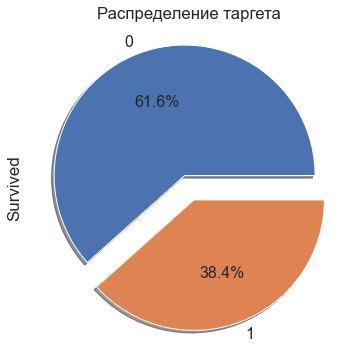

In [10]:
plt.figure(figsize=(6, 6))

train['Survived'].value_counts().plot.pie(explode=[0.1, 0.1], autopct='%1.1f%%',
                                          shadow=True, textprops={'fontsize': 16}).set_title('Распределение таргета')

Дисбаланс подтвердился

## Количественные признаки

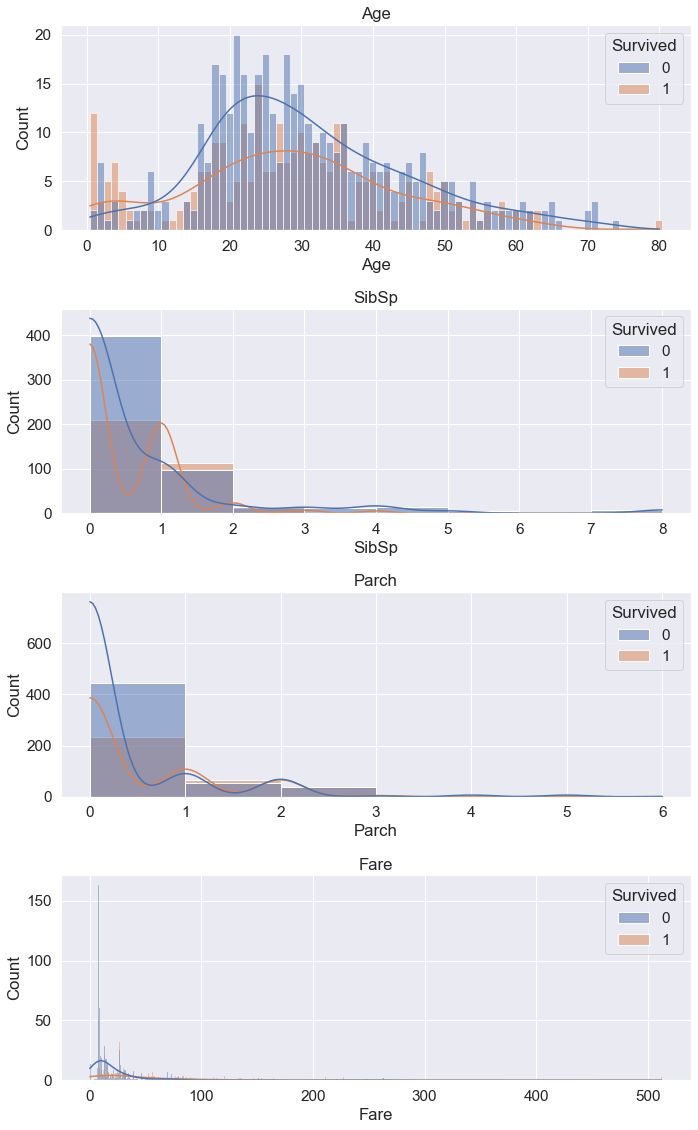

In [11]:
quants = ['Age', 'SibSp', 'Parch', 'Fare']

fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(quants):
    ax=fig.add_subplot(4,1,i+1)
    sns.histplot(data=train, x=var_name, axes=ax, hue='Survived', kde=True, binwidth=1)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

*Наблюдения*:
* У детей до 7-8 лет шансов выжить больше, чем у остальных пассажиров. Вероятно эвакуировали сначала детей.
* У молодых людей (16-35 лет) шансы выжить наоборот меньше
* Пассажиры, путешествующие без родных, с большей вероятностью погибают

*Идеи*:
* Создать возрастные группы пассажиров
* Создать признак - сумму SibSp и Parch

In [12]:
train[train['Fare'] > 200]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
380,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S


Я бы все-таки не сказал, что стоимоть проезда 512 единиц - выброс. Но для наглядности графика ограничим его по оси X

(0.0, 50.0)

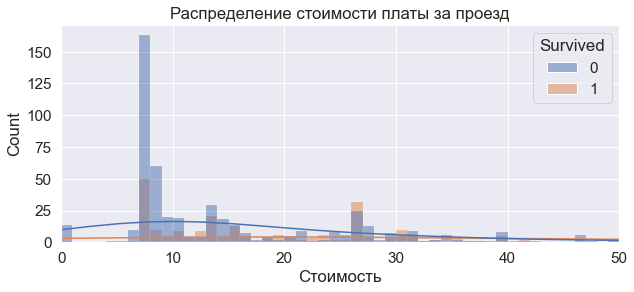

In [13]:
plt.figure(figsize=(10, 4))

sns.histplot(data=train, x='Fare', hue='Survived', binwidth=1, kde=True)

plt.title('Распределение стоимости платы за проезд')
plt.xlabel('Стоимость')
plt.xlim([0, 50])

*Наблюдения*:

* В районе 8-10 единиц люди умирали за себя и за Сашку. 
* Распределение сильно скошено вправо.

*Идеи:*
* Разбить стоимость проезда на группы
* Прологарифмировать этот столбец

## Категориальные признаки

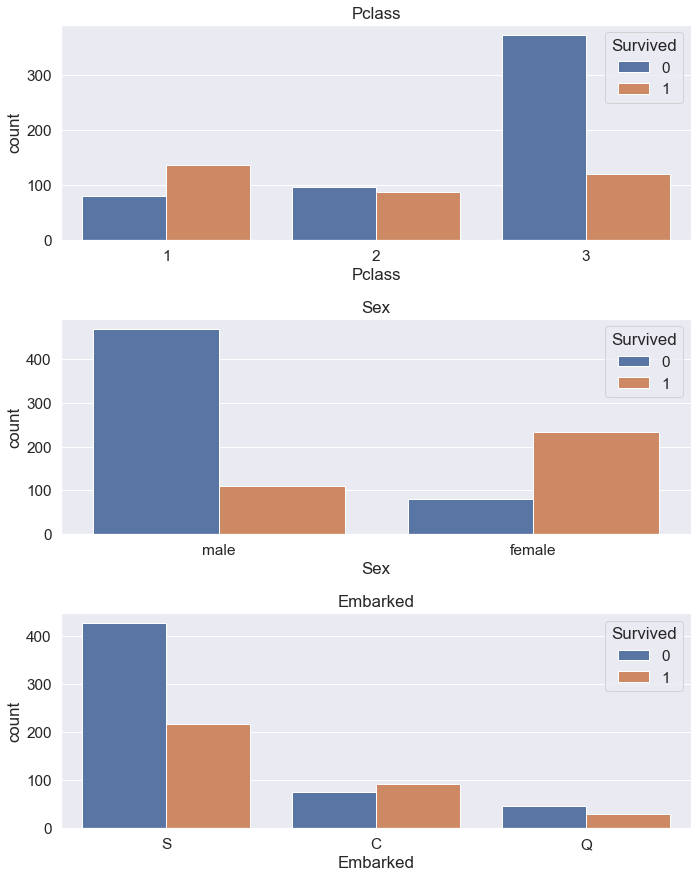

In [14]:
cats = ['Pclass', 'Sex', 'Embarked']

fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Survived')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

*Наблюдения:*

* Пассажиры с низким СЭС с большей вероятностью погибают;
* Женщины с большей вероятностью выживают;
* Пассажиры, которые сели в Саунтгемптоне, с большей вероятностью погибают

## Качественные признаки

In [15]:
quals = ['PassengerId', 'Name', 'Cabin', 'Ticket']

train[quals].head()

,PassengerId,Name,Cabin,Ticket
0,1,"Braund, Mr. Owen Harris",NaN,A/5 21171
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,PC 17599
2,3,"Heikkinen, Miss. Laina",NaN,STON/O2. 3101282
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,113803
4,5,"Allen, Mr. William Henry",NaN,373450


*Наблюдения:*

* PassengerId нам никакой информации не даст;
* Из имени можно предположить, что до запятой идет фамилия. Тогда можно будет сгруппировать пассажиров с одной фамилией, что возможно поможет с заполнением пропусков в кабинах (если они взаимосвязаны). Также можно вытянуть инициал Mr/Mrs. Плюс непонятно, что значит имя в скобках
* В Cabin так же не понимаю логику присвоения номеров, однако из-за того, что более 70% данных пропущено, использовать эту фичу мы не можем
* С билетами та же история: номера как-будто рандомные

*Идеи*:

* Создать фичу с фамилией и инициалом пассажиров

# Feature engeneering

## Возраст

Возрастные группы определим перебором разбиения через pd.cut, потом составим собственные

,Age_group,Survived
0,"(0.34, 6.542]",0.702128
1,"(6.542, 12.663]",0.318182
2,"(12.663, 18.785]",0.428571
3,"(18.785, 24.906]",0.345324
4,"(24.906, 31.028]",0.373333
5,"(31.028, 37.149]",0.459184
6,"(37.149, 43.271]",0.390625
7,"(43.271, 49.392]",0.380000
8,"(49.392, 55.514]",0.428571
9,"(55.514, 61.635]",0.350000


<AxesSubplot:xlabel='Age_group', ylabel='count'>

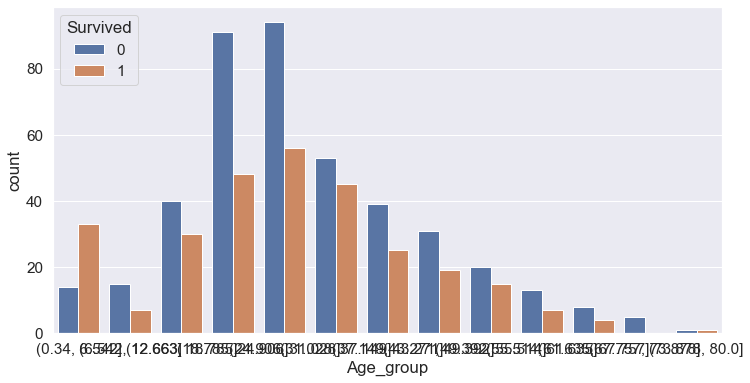

In [16]:
train['Age_group'] = pd.cut(train['Age'], 13)
display(train[['Age_group', 'Survived']].groupby(['Age_group'], as_index=False).mean().sort_values(
    by='Age_group', ascending=True))

plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='Age_group', hue='Survived')

По графику выше видны группы с похожим соотношением выживаемости: (0.34, 6.542], (6.542, 18.785], (18.785, 31.028], (31.028, 37.149], (37.149, 67.757], (67.757, 80.0]. 

In [17]:
dfs = [train, test]

Text(0.5, 1.0, 'Распределение возрастных групп')

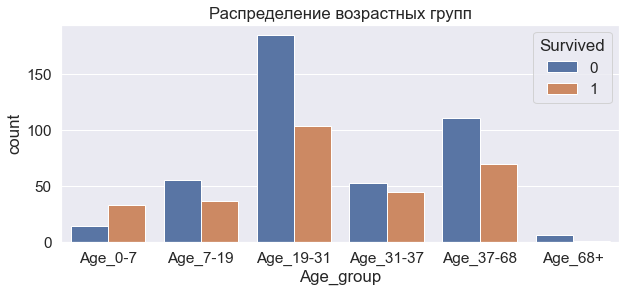

In [18]:
#Новый признак - 7 возрастных групп
for df in dfs:
    df['Age_group'] = np.nan
    df.loc[df['Age'] <= 6.542, 'Age_group'] = 'Age_0-7'
    df.loc[(df['Age'] > 6.542) & (df['Age'] <= 18.785), 'Age_group'] = 'Age_7-19'
    df.loc[(df['Age'] > 18.785) & (df['Age'] <= 31.028), 'Age_group'] = 'Age_19-31'
    df.loc[(df['Age'] > 31.028) & (df['Age'] <= 37.149), 'Age_group'] = 'Age_31-37'
    df.loc[(df['Age'] > 37.149) & (df['Age'] <= 67.757), 'Age_group'] = 'Age_37-68'
    df.loc[df['Age'] > 67.757, 'Age_group'] = 'Age_68+'

# Нарисуем распределения новых фич
plt.figure(figsize=(10, 4))

sns.countplot(data=train, x='Age_group', hue='Survived',
              order=['Age_0-7', 'Age_7-19', 'Age_19-31', 'Age_31-37', 'Age_37-68', 'Age_68+'])
plt.title('Распределение возрастных групп')

## Размер семьи

Text(0.5, 1.0, 'Количество сопровождающих')

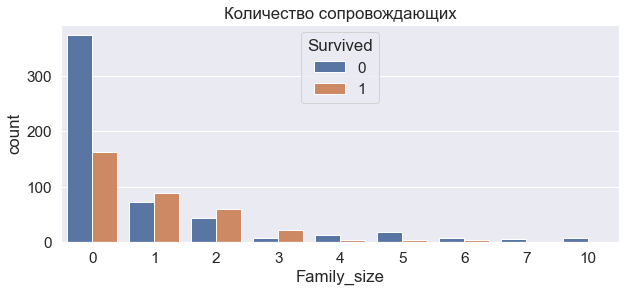

In [19]:
# Просуммируем SibSp и Parch
for df in dfs:
    df['Family_size'] = df['SibSp'] + df['Parch']
    # Сразу избавляемся от лишних признаков
    df.drop(['Parch', 'SibSp'], axis=1, inplace=True)

# Нарисуем распределения новых фич
plt.figure(figsize=(10, 4))

sns.countplot(data=train, x='Family_size', hue='Survived')
plt.title('Количество сопровождающих')

## Стоимость проезда

По той же схеме, только теперь через qcut

,Fare_group,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


<AxesSubplot:xlabel='Fare_group', ylabel='count'>

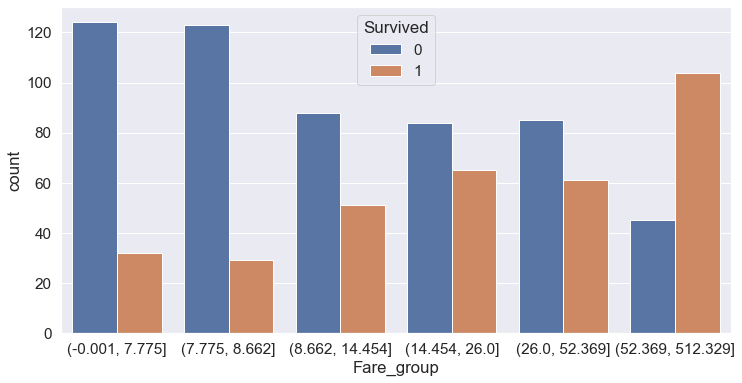

In [20]:
train['Fare_group'] = pd.qcut(train['Fare'], 6)
display(train[['Fare_group', 'Survived']].groupby(['Fare_group'], as_index=False).mean().sort_values(
    by='Fare_group', ascending=True))

plt.figure(figsize=(12,6))
sns.countplot(data=train, x='Fare_group', hue='Survived')

Выделяем: (-0.001,  8.662], (8.662, 52.369], (52.369, 512.329]

Text(0.5, 1.0, 'Дешевые/средние/дорогие поездки')

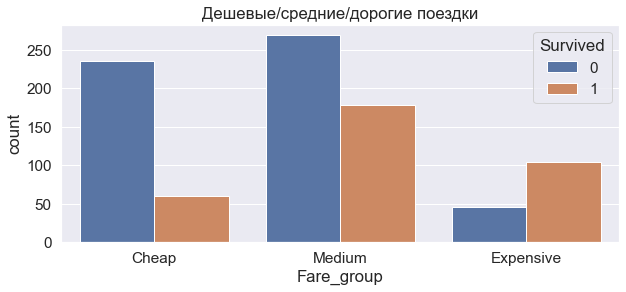

In [21]:
for df in dfs:
    df['Fare_group'] = np.nan
    df.loc[df['Fare'] <= 8.662, 'Fare_group'] = 'Cheap'
    df.loc[(df['Fare'] > 8.662) & (df['Fare'] <= 52.369), 'Fare_group'] = 'Medium'
    df.loc[df['Fare'] > 52.369, 'Fare_group'] = 'Expensive'

# Нарисуем распределения новых фич
plt.figure(figsize=(10, 4))

sns.countplot(data=train, x='Fare_group', hue='Survived', order=['Cheap', 'Medium', 'Expensive'])
plt.title('Дешевые/средние/дорогие поездки')

## Mr/Mrs

In [22]:
# Создаем признак - инициал пассажира
for df in dfs:
    df['Initial']=df['Name'].str.split(".").str[0].str.split(',').str[-1].str.strip()
    df.drop('Name', axis=1, inplace=True)

train['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [23]:
train.groupby(['Initial'])['Age'].agg(['mean', 'count']).sort_values('mean')

,mean,count
Initial,,
Master,4.574167,36
Miss,21.773973,146
Mme,24.000000,1
Mlle,24.000000,2
Ms,28.000000,1
Mr,32.368090,398
the Countess,33.000000,1
Mrs,35.898148,108
Jonkheer,38.000000,1


Видим, что инициалом очень много, однако многие встречаются один-два раза и средний возраст между разными группами совпадает. Проще объединить группы в 5 общих:

* Master - 5 лет
* Miss - 22 года
* Mr - 33 года
* Mrs - 36 лет
* Other - кто никуда не подойдет

In [24]:
for df in dfs:
    df['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'the Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don'], [
        'Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr'], inplace=True)

Text(0.5, 1.0, 'Initials')

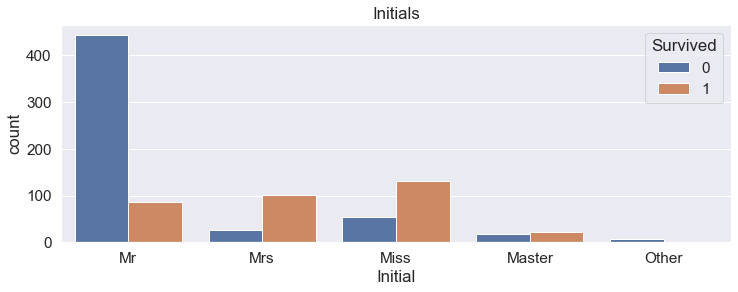

In [25]:
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Initial', hue='Survived')
plt.title('Initials')

Есть подозрение, что эта фича будет сильно коррелировать с полом

# Пропуски

Объединим train и test, так проще обработать пропуски

In [26]:
y=train['Survived'].copy().astype(int)
X=train.drop('Survived', axis=1).copy()

#Объединяем датафреймы
data=pd.concat([X, test], axis=0).reset_index(drop=True)

Посмотрим, насколько все плохо

In [27]:
# Создаем список из столбцов с хотя бы одним пропуском
na_cols=data.columns[data.isna().any()].tolist()

# Считаем количесвто пропусков и процент от общего числа
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
Age,263,20.09
Fare,1,0.08
Cabin,1014,77.46
Embarked,2,0.15
Age_group,263,20.09
Fare_group,1,0.08


Text(0.5, 1.0, 'Heatmap of missing values')

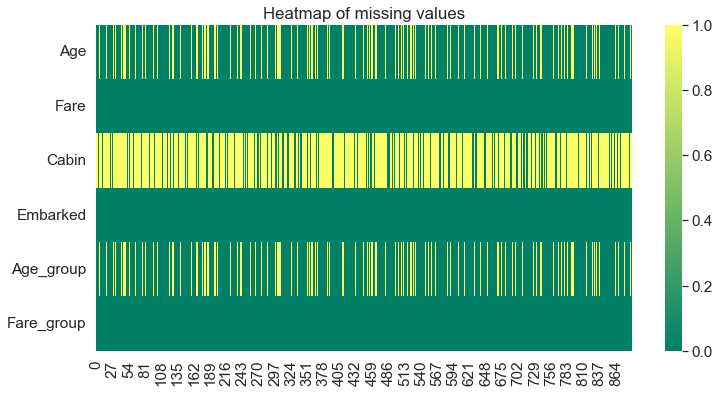

In [28]:
# Heatmap пропусков
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

77% данных о кабинах пропущены, 20% о возрасте. Беда

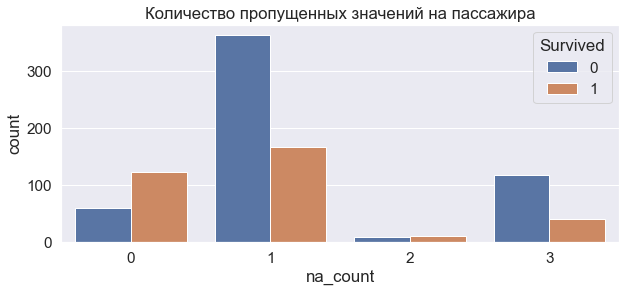

In [29]:
# Countplot of number of missing values by passenger
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Survived')
plt.title('Количество пропущенных значений на пассажира')
train.drop('na_count', axis=1, inplace=True)

*Наблюдения:*

* Пропуски зависимы от целевого признака
* Большая часть пассажиров имеет хотя бы один пропуск
* В признаке Cabin больше 77% пропусков, столько восстановить мы не сможем. Хоть фича и информативная, от нее придется избавиться

In [30]:
data = data.drop('Cabin', axis=1)

## Инициал и возраст

Возраст заполним медианными значениями согласно инициалам

In [31]:
data.groupby(['Initial'])[['Age']].median().sort_values('Age')

,Age
Initial,
Master,4.0
Miss,22.0
Mr,30.0
Mrs,35.5
Dona,39.0
Other,47.0


In [32]:
A_prev = data['Age'].isna().sum()

data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=29
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=9
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=24
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=42

print('Пропуски в возрасте до заполнения:', A_prev)
print('Пропуски в возрасте после заполнения:', data['Age'].isna().sum())

Пропуски в возрасте до заполнения: 263
Пропуски в возрасте после заполнения: 0


Обновим теперь Age_group

In [33]:
data['Age_group'] = np.nan
data.loc[data['Age'] <= 6.542, 'Age_group'] = 'Age_0-7'
data.loc[(data['Age'] > 6.542) & (data['Age'] <= 18.785), 'Age_group'] = 'Age_7-19'
data.loc[(data['Age'] > 18.785) & (data['Age'] <= 31.028), 'Age_group'] = 'Age_19-31'
data.loc[(data['Age'] > 31.028) & (data['Age'] <= 37.149), 'Age_group'] = 'Age_31-37'
data.loc[(data['Age'] > 37.149) & (data['Age'] <= 67.757), 'Age_group'] = 'Age_37-68'
data.loc[data['Age'] > 67.757, 'Age_group'] = 'Age_68+'

In [34]:
data.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
Ticket         0
Fare           1
Embarked       2
Age_group      0
Family_size    0
Fare_group     1
Initial        0
dtype: int64

## Embarked

In [35]:
# Заполним просто модой - S
data.loc[data['Embarked'].isna(), 'Embarked'] = 'S'

In [36]:
data.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
Ticket         0
Fare           1
Embarked       0
Age_group      0
Family_size    0
Fare_group     1
Initial        0
dtype: int64

## Fare - Pclass

Заполним медианными значениями стоимость проезда для соответствующего СЭС

In [37]:
data.groupby(['Pclass'])['Fare'].median()

Pclass
1    60.0000
2    15.0458
3     8.0500
Name: Fare, dtype: float64

In [38]:
data[data['Fare'].isna()]

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Embarked,Age_group,Family_size,Fare_group,Initial
1043,1044,3,male,60.5,3701,NaN,S,Age_37-68,0,NaN,Mr


In [39]:
data.loc[data['Fare'].isna(), 'Fare'] = 8.05

Теперь обновим признак Cheap_fare

In [40]:
data['Fare_group'] = np.nan
data.loc[data['Fare'] <= 8.662, 'Fare_group'] = 'Cheap'
data.loc[(data['Fare'] > 8.662) & (data['Fare'] <= 52.369), 'Fare_group'] = 'Medium'
data.loc[data['Fare'] > 52.369, 'Fare_group'] = 'Expensive'

In [41]:
data.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
Ticket         0
Fare           0
Embarked       0
Age_group      0
Family_size    0
Fare_group     0
Initial        0
dtype: int64

От всех пропусков избавились

# Preprocessing

**Возвращаем обратно train и test**

In [42]:
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

Выкидываем ненужные признаки

In [43]:
X.drop(['PassengerId', 'Ticket', 'Fare_group', 'Initial', 'Age_group'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Ticket', 'Fare_group', 'Initial', 'Age_group'], axis=1, inplace=True)

**Log transform**

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Sex          891 non-null    object 
 2   Age          891 non-null    float64
 3   Fare         891 non-null    float64
 4   Embarked     891 non-null    object 
 5   Family_size  891 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 48.7+ KB


In [45]:
# # Plot log transform results
# fig=plt.figure(figsize=(12,20))

# plt.subplot(6,2,1)
# sns.histplot(X['Fare'], binwidth=10)
# plt.title(f'Fare original')

# plt.subplot(6,2,2)
# sns.histplot(np.log(1+X['Fare']), color='C1')
# plt.title(f'Fare log-transform')
    
# fig.tight_layout()
# plt.show()

In [46]:
# X['Fare'] = np.log(1+X['Fare'])
# X_test['Fare'] = np.log(1+X_test['Fare'])

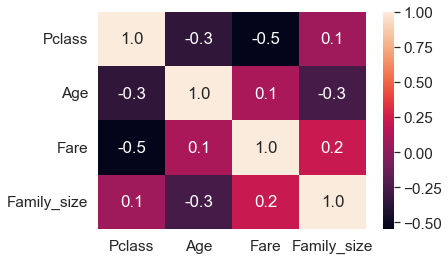

In [47]:
sns.heatmap(X.corr(), annot=True, fmt=".1f");

**Encoding and scaling**

In [48]:
# Обозначаем количественные и котегориальные фичи
numerical_cols = [
    cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Масштабируем данные со средним = 0 и дисперсией = 1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(
    drop='if_binary', handle_unknown='ignore', sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
    remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape:', X.shape)

Training set shape: (891, 8)


In [49]:
# Создаем валидационный сет

X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=17)

# Model Selection

Зададим модели  и сетку параметров для GridSearchCV

In [50]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=17),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=17, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=17),
    #"XGBoost" : XGBClassifier(random_state=17, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=17),
    "CatBoost" : CatBoostClassifier(random_state=17, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

**Train and evaluate**

Обучим модели через GridSearch (без кросс-валидации скорости ради) и выберем лучшую модель

In [51]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame({'Classifer': classifiers.keys(), 'Validation accuracy': np.zeros(
    len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier,
                       param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i, 1] = clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key] = clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i, 2] = np.round((stop - start), 2)

    print('Model:', key)
    print('Training time (sec):', valid_scores.iloc[i, 2])
    print('')
    i += 1

Model: LogisticRegression
Training time (sec): 3.11

Model: KNN
Training time (sec): 0.1

Model: SVC
Training time (sec): 0.84

Model: RandomForest
Training time (sec): 4.84

Model: LGBM
Training time (sec): 0.99

Model: CatBoost
Training time (sec): 42.49

Model: NaiveBayes
Training time (sec): 0.13



In [52]:
# Результаты
valid_scores.sort_values('Validation accuracy', ascending=False)

,Classifer,Validation accuracy,Training time
2,SVC,0.832402,0.84
3,RandomForest,0.826816,4.84
4,LGBM,0.826816,0.99
5,CatBoost,0.821229,42.49
1,KNN,0.782123,0.10
6,NaiveBayes,0.776536,0.13
0,LogisticRegression,0.770950,3.11


Возьмем отсюда LGBM и CatBoost

# Modelling

Обозначим лучшие модели

In [53]:
# Classifiers
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=17),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=17),
}

**Кросс-валидация и общие предсказания**

Предсказания с двух моделей собраны вместе. Так получим усредненную вероятность для получения наиболее уверенных прогнозов

In [54]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=17)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

Model: LGBM
Average validation accuracy: 84.17
Training time (mins): 0.01

Model: CatBoost
Average validation accuracy: 82.38
Training time (mins): 0.34



# Вывод результатов

Посмотрим на распределение вероятностей

Text(0.5, 0, 'Probability')

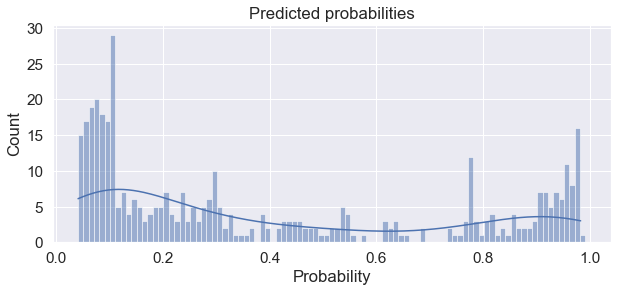

In [55]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

Optimal threshold: 0.244


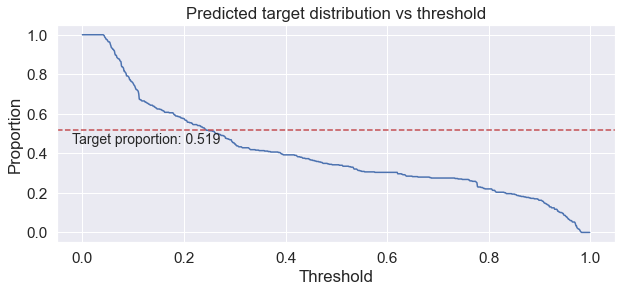

In [62]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.519         # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

Для первого раза поставим стандартный порог для определения принадлежности к классу: 0.6

In [63]:
preds_tuned=(preds>=T_opt).astype(int)

**Предсказания**

Text(0.5, 1.0, 'Prediction distribution')

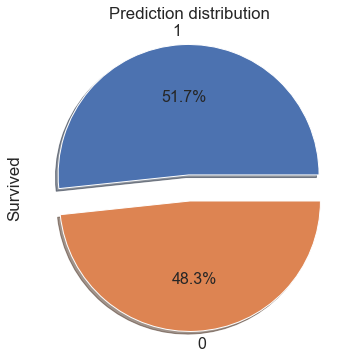

In [64]:
# Sample submission (to get right format)
sub = pd.read_csv('gender_submission.csv')

# Add predictions
sub['Survived'] = preds_tuned

# # Replace 0 to False and 1 to True
# sub = sub.replace({0: False, 1: True})

# Prediction distribution
plt.figure(figsize=(6, 6))
sub['Survived'].value_counts().plot.pie(explode=[0.1, 0.1], autopct='%1.1f%%',
                                           shadow=True, textprops={'fontsize': 16}).set_title("Prediction distribution")

In [65]:
# Выводим в csv
sub.to_csv('submission.csv', index=False)

**References:**
* https://www.kaggle.com/code/odaymourad/detailed-and-typical-solution-ensemble-modeling
* https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide
